# Q2 Part C Using Prophet

In [1]:
import pandas as pd
import numpy as np
import prophet

# Data Preprocessing

In [ ]:
# Data reading and pre-processing
df = pd.read_csv('AirtrafficA4.csv')
df['YEAR'] = df['YEAR'].astype(str)
df['MONTH'] = df['MONTH'].astype(str)
df['DATE'] = df['YEAR'] + '-' + df['MONTH']
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df.drop(['YEAR', 'MONTH','AIRLINE'], axis=1, inplace=True)  #These feature are of no use
df.sort_index(inplace=True)
for column in df.columns:
    if df[column].dtype == 'object':  # Check if the column is of type object (likely string)
        df[column] = df[column].str.replace(',', '').astype(float) # Remove commas if present and convert to float

df = df.apply(pd.to_numeric, errors='coerce')
df.columns

In [3]:
# check correlation between the columns of the dataframe
df.corr()
# next we need to add the covid indicator

,TOTAL DEPARTURES,HOURS FLOWN,KILOMETRE FLOWN,PASSENGERS CARRIED,AVAILABLE SEAT KILOMETRE (IN THOUSAND),FREIGHT CARRIED (IN TONNE),MAIL CARRIED (IN TONNE)
TOTAL DEPARTURES,1.000000,0.998041,0.998026,0.983746,0.998149,0.916947,0.794591
HOURS FLOWN,0.998041,1.000000,0.998381,0.983929,0.996486,0.910423,0.791782
KILOMETRE FLOWN,0.998026,0.998381,1.000000,0.986037,0.998117,0.909556,0.790224
PASSENGERS CARRIED,0.983746,0.983929,0.986037,1.000000,0.985752,0.877325,0.746415
AVAILABLE SEAT KILOMETRE (IN THOUSAND),0.998149,0.996486,0.998117,0.985752,1.000000,0.909993,0.791017
FREIGHT CARRIED (IN TONNE),0.916947,0.910423,0.909556,0.877325,0.909993,1.000000,0.766192
MAIL CARRIED (IN TONNE),0.794591,0.791782,0.790224,0.746415,0.791017,0.766192,1.000000


In [4]:
df['DATE'] = df.index
# df['PASSENGERS CARRIED']
data = df['PASSENGERS CARRIED'].fillna(0)
data = data.to_numpy()
# data.fillna(0)
data = data.astype(int)

# make a new df using only the date and passengers carried column with names as ds and y
df1 = pd.DataFrame({'ds': df['DATE'], 'y': data, 'hours': df['HOURS FLOWN'],'freight': df[' FREIGHT CARRIED (IN TONNE)'], 'mail': df['MAIL CARRIED (IN TONNE)'], 'seats':df['AVAILABLE SEAT KILOMETRE (IN THOUSAND)'], 'dept':df['TOTAL DEPARTURES'], 'kilo':df['KILOMETRE FLOWN']})
# df1 = pd.DataFrame({'ds': df['DATE'], 'y': data
df1['hours'] = df1['hours'].fillna(0)
df1['freight'] = df1['freight'].fillna(0)
df1['mail'] = df1['mail'].fillna(0)
df1['seats'] = df1['seats'].fillna(0)
df1['dept'] = df1['dept'].fillna(0)
df1['kilo'] = df1['kilo'].fillna(0)
df1.head()
# add a covid field with boolean values 1 between 2020 and 2022
df['covid'] = 0
df.loc[(df['DATE'] >= '2020-01-01') & (df['DATE'] <= '2022-10-31'), 'covid'] = 1
df1['covid'] = 0
df1.loc[(df1['ds'] >= '2020-01-01') & (df1['ds'] <= '2022-10-31'), 'covid'] = 1
df1.head()

,ds,y,hours,freight,mail,seats,dept,kilo,covid
DATE,,,,,,,,,
2013-01-01,2013-01-01,1408012,18655.0,6465.0,0.0,1820105.0,10552.0,10112.0,0
2013-02-01,2013-02-01,1341210,17374.0,6235.0,0.0,1698930.0,9873.0,9439.0,0
2013-03-01,2013-03-01,1423569,20093.0,6505.0,0.0,1984886.0,11393.0,11028.0,0
2013-04-01,2013-04-01,1511094,20084.0,5903.0,0.0,1996084.0,11426.0,11090.0,0
2013-05-01,2013-05-01,1685168,20779.0,7345.0,0.0,2075882.0,11885.0,11533.0,0


In [5]:
model = prophet.Prophet()
# model.add_regressor('hours')
# model.add_regressor('freight')
# model.add_regressor('mail')
# model.add_regressor('seats')
model.add_regressor('covid')
# model.add_regressor('dept')
# model.add_regressor('kilo')
model.fit(df1)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplcrejn81/25zm39tq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplcrejn81/3zarysec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17057', 'data', 'file=/tmp/tmplcrejn81/25zm39tq.json', 'init=/tmp/tmplcrejn81/3zarysec.json', 'output', 'file=/tmp/tmplcrejn81/prophet_modelxtzvdho8/prophet_model-20241028162233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [13]:
# predict values for 10 points differing by 1 month
# predict values for 10 points differing by 1 month using regressors
future = model.make_future_dataframe(periods=12, freq='M')
# add future columns for hours and freight
# df['HOURS FLOWN'] = df['HOURS FLOWN'].fillna(0)
# # df[' FREIGHT CARRIED (IN TONNE)'] = df[' FREIGHT CARRIED (IN TONNE)'].fillna(0)
# # df['MAIL CARRIED (IN TONNE)'] = df['MAIL CARRIED (IN TONNE)'].fillna(0)
# df['AVAILABLE SEAT KILOMETRE (IN THOUSAND)'] = df['AVAILABLE SEAT KILOMETRE (IN THOUSAND)'].fillna(0)
# df['KILOMETRE FLOWN'] = df['KILOMETRE FLOWN'].fillna(0)
# df['TOTAL DEPARTURES'] = df['TOTAL DEPARTURES'].fillna(0)
# future['mail'] = df['MAIL CARRIED (IN TONNE)
# future['hours'] = df['HOURS FLOWN'] # Or any suitable value or logic for future 'hours'
# future['freight'] = df[' FREIGHT CARRIED (IN TONNE)']
#set integers as index of df
df2=df.copy()
df2=df2.reset_index(drop = True)
print(df2['covid'])
# future['hours'] = df2['HOURS FLOWN']
# future['freight'] = df2[' FREIGHT CARRIED (IN TONNE)']
# future['mail'] = df2['MAIL CARRIED (IN TONNE)']
# future['seats'] = df2['AVAILABLE SEAT KILOMETRE (IN THOUSAND)']
future['covid'] = 0
# future.loc[(df['DATE'] >= '2020-01-01') & (df['DATE'] <= '2022-10-31'), 'covid'] = 1
for i in range(84,108):
    future.loc[i, 'covid'] = 1
# future['covid'] = df2['covid']
print(future['covid'])
# future['dept'] = df2['TOTAL DEPARTURES']
# future['kilo'] = df2['KILOMETRE FLOWN']
# df1['hours'] = df1['hours'].fillna(0)
# df1['freight'] = df1['freight'].fillna(0)
# df['HOURS FLOWN'] = df['HOURS FLOWN'].fillna(0)
# df[' FREIGHT CARRIED (IN TONNE)'] = df[' FREIGHT CARRIED (IN TONNE)'].fillna(0)
# future['hours'] = df['HOURS FLOWN'] # Or any suitable value or logic for future 'hours'
# future['freight'] = df[' FREIGHT CARRIED (IN TONNE)']
# Predict future values
forecast = model.predict(future)

0      0
1      0
2      0
3      0
4      0
      ..
123    0
124    0
125    0
126    0
127    0
Name: covid, Length: 128, dtype: int64
0      0
1      0
2      0
3      0
4      0
      ..
135    0
136    0
137    0
138    0
139    0
Name: covid, Length: 140, dtype: int64


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [14]:
import matplotlib.pyplot as plt
import numpy as np
# Predict future values
forecast = model.predict(future)
# print(forecast['yhat'].tail(12))
# convert the datatype to int
forecast['yhat'] = forecast['yhat'].astype(int)
print(forecast['yhat'].tail(12))
# printing the forecast of passengers carried for the next 12 months from 2023 September to 2024 August

128    7979921
129    8327354
130    8232106
131    8531379
132    8621485
133    8515347
134    8562909
135    8259864
136    8416499
137    8324873
138    8399318
139    8535761
Name: yhat, dtype: int64


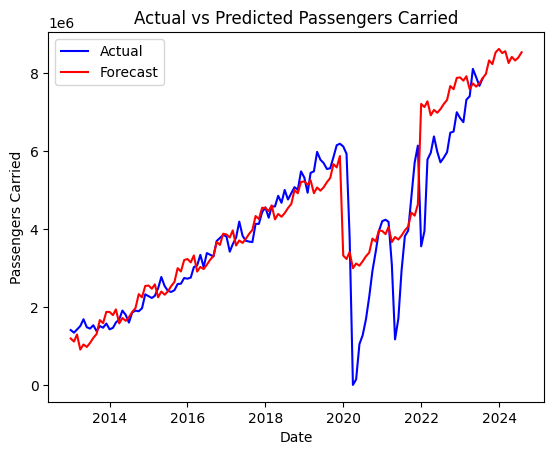

In [17]:
import matplotlib.pyplot as plt

# Plot actual values
plt.plot(df1['ds'], df1['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Passengers Carried')
plt.title('Actual vs Predicted Passengers Carried')
plt.legend()

# Show the plot
plt.show()